<a href="https://colab.research.google.com/github/marabian/toxic-comment-classification/blob/master/toxic-comment-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Toxic Comment Classification
***

[Link to Kaggle challenge/dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/)


In [5]:
import os
import random as rnd

# data analysis and wrangling
import pandas as pd
import numpy as np


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
# to mount google drive for colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
# check gpu support
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
# check if gpu working
# tf.test.gpu_device_name()

In [9]:
# change notebook theme
!jt -t oceans16 -T -N -kl

## Workflow


* Defining the problem and assembling a dataset<br>


* Choosing a measure of success


* Deciding on an evaluation protocol


* Preparing your data for ML algorithms


* Developing a model that does better than a baseline


* Scaling up: developing a model that overfits


* Regularizing your model and tuning your hyperparameters



## Defining the problem and assembling a dataset
***


We are challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. Our training data will consist of ~160,000 comments from Wikipedia’s talk page edits with labeled levels of toxicity. Detecting toxic comments online will hopefully help online discussion become more productive and respectful.<br>

Since we have many classes, this problem is an instance of multiclass classification; and because each data point could belong to multiple categories (in this case, levels of toxicity), this is a **multilabel, multiclass classification problem**.

We will start with a solving a subset of this problem, using **binary classification** to classify between "good" and "toxic" comments.

In [8]:
path_to_data = "/content/drive/My Drive/machine learning/notebooks/data/jigsaw-toxic-comment-classification-challenge/"

In [10]:
path_to_data = "data/"

In [11]:
train_df = pd.read_csv(path_to_data + "train.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


Let's build a new dataframe containing just the training examples for our binary classification problem.

In [12]:
bin_df = pd.concat([
           train_df[train_df[labels].eq(0).all(1)][['id', 'comment_text', 'toxic']], # get new df with rows for "good" comments
           train_df[train_df['toxic'] == 1][['id', 'comment_text', 'toxic']]] # get new dataframe with rows for "toxic" comments
         ).reset_index(drop=True)

In [13]:
bin_df

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
158635,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1
158636,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
158637,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1
158638,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1


**Plot distribution of toxic comment frequency**

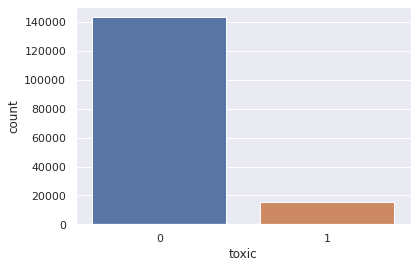

In [14]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="toxic", data=bin_df)

In [15]:
print(bin_df['toxic'].value_counts())

0    143346
1     15294
Name: toxic, dtype: int64


As we can see, our classes are heavily imbalanced. There are a lot more "good" comments than "toxic". To deal with this class imbalance problem, we will choose ***precision and recall*** as our **evaluation metric**. This will be our measure of success.

## Preparing the raw text data
***

Let's start doing some text preprocessing! In NLP, the main steps to preprocess raw text into tensors includes the following steps:<br> ***word tokenization***, ***text cleaning*** (lowercasing, removing stop words and punctuation, stemming), and ***text vectorization***.

Our first *vectorization scheme* will be using **TF-IDF vectors** for the  most common words found in our corpus.

In information retrieval, **TF-IDF**, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use *Scikit-Learn's* awesome **TfidfVectorizer** to convert a collection of raw documents to a matrix of TF-IDF features. This does all the text preprocessing steps we need.

### Bulding feature vectors using TF-IDF

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase='True', stop_words='english', max_features=10)
X = vectorizer.fit_transform(bin_df.comment_text)

print(vectorizer.get_feature_names())
print(X.shape)

['article', 'don', 'just', 'know', 'like', 'page', 'people', 'talk', 'think', 'wikipedia']
(158640, 10)


In order to get a better idea on how many words to consider as features, let's visualize the distribution of word counts amongst our training examples. In order to do this, we must first preprocess the raw text data ourselves. Let's define a function to preprocess the comments by *tokenizing* and *cleaning*.

In [18]:
import re
import string
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# stemmer
stemmer = PorterStemmer()

# stop words
nltk.download('stopwords')
nltk.download('punkt')
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marabian/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/marabian/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [106]:
def process_comment(comment):
    """Process comment function.
    Input:
        comment: a string containing a comment
    Output:
        comment_clean: a list of cleaned word tokens

    """

    # normalizing case
    comment = comment.lower()

    # remove special characters
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    comment = re.sub(pat, '', comment)

    # remove numbers
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    comment = re.sub(pattern, '', comment)
    
    # remove punctuation in comment and stopwords
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    stopwords = [word.translate(str.maketrans('', '', string.punctuation)) for word in stopwords_english]
    
    # replace repeated character sequences of length 3 or greater with sequences of length 3
    comment = nltk.tokenize.casual.reduce_lengthening(comment)
    
    # tokenize comment
    tokens = word_tokenize(comment)
    
    # remove stop words and stem
    comment_clean = [stemmer.stem(token) for token in tokens if token not in stopwords]
    #comment_clean = [token for token in tokens if token not in stopwords]

    return comment_clean

In [47]:
bin_df.comment_text

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
158635    "\n\n our previous conversation \n\nyou fuckin...
158636                    YOU ARE A MISCHIEVIOUS PUBIC HAIR
158637    Your absurd edits \n\nYour absurd edits on gre...
158638    "\n\nHey listen don't you ever!!!! Delete my e...
158639    and i'm going to keep posting the stuff u dele...
Name: comment_text, Length: 158640, dtype: object

Let's clean our entire dataset using the *process_comment* function we just defined, we will store the cleaned comments in a new column.

In [49]:
bin_df['cleaned_comments'] = bin_df['comment_text'].apply(process_comment)

In [59]:
bin_df['word_count'] = bin_df['cleaned_comments'].apply(len)

In [60]:
bin_df

,id,comment_text,toxic,cleaned_comments,word_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,"[explan, edit, made, usernam, hardcor, metalli...",24
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,"[daww, match, background, colour, im, seemingl...",11
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, im, realli, tri, edit, war, guy, co...",22
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,"[cant, make, real, suggest, improv, wonder, se...",49
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chanc, rememb, page, that]",6
...,...,...,...,...,...
158635,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,"[previou, convers, fuck, shit, eat, liber, mak...",173
158636,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,"[mischievi, pubic, hair]",3
158637,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,"[absurd, edit, absurd, edit, great, white, sha...",28
158638,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,"[hey, listen, ever, delet, edit, ever, im, ann...",49


Now we can visualize the distribution of word counts in all comments.

<AxesSubplot:xlabel='word_count', ylabel='Count'>

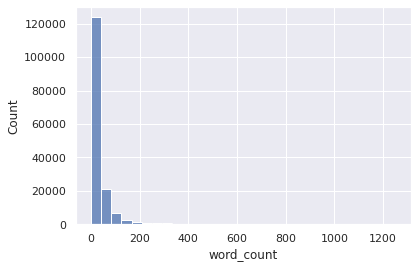

In [82]:
sns.histplot(data=bin_df, x="word_count", bins=30)

Visualize the distribution of word counts in good comments.

<AxesSubplot:xlabel='word_count', ylabel='Count'>

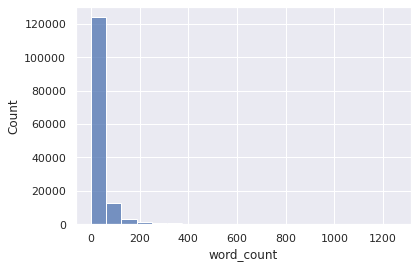

In [95]:
sns.histplot(x=bin_df[bin_df['toxic'] == 0]['word_count'], bins=20)

Visualize the distribution of word counts in bad comments.

<AxesSubplot:xlabel='word_count', ylabel='Count'>

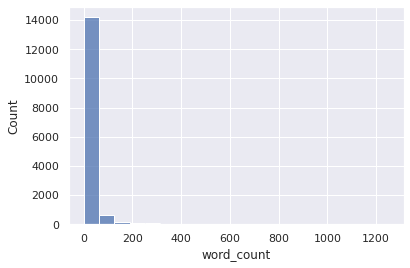

In [94]:
sns.histplot(x=bin_df[bin_df['toxic'] == 1]['word_count'], bins=20)

Seems like the distributions are roughly the same. Most comments contain ~100 words. We will use this as our **max_features**. Our **evaluation protocol** will be maintaining a **hold-out validation set**. Now let's split up our dataset into randomized training and validation sets. Since our classes are imbalanced, it is important that both the training and validation sets have the same ratio of "good" to "bad" comments.<br><br>We will use *Scikit-Learn's* **train_test_split** function with *stratified* sampling to do this:

In [97]:
from sklearn.model_selection import train_test_split

# train test split
train, test = train_test_split(bin_df, test_size = 0.2, stratify = bin_df['toxic'], random_state=21)

# get the shape of train and test split.
print(train.shape, test.shape)

(126912, 5) (31728, 5)


Let's create a ***TF-IDF vector*** of the *comment_text* column using the **TfidfVectorizer**. We will keep *max features* as 100 and use our own *tokenizer* function.

In [107]:
# create a TF-IDF vectorizer object
vectorizer = TfidfVectorizer(tokenizer=process_comment, max_features=100)

# fit the object with the training data comments
vectorizer.fit(train.comment_text)

/home/marabian/.venv/tf_venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=100,
                tokenizer=<function process_comment at 0x7f391c4ce6a8>)

In [119]:
print(vectorizer.get_feature_names())

['actual', 'ad', 'add', 'also', 'articl', 'ask', 'back', 'block', 'call', 'chang', 'comment', 'consid', 'content', 'contribut', 'could', 'creat', 'delet', 'discuss', 'edit', 'editor', 'even', 'fact', 'find', 'first', 'fuck', 'get', 'go', 'good', 'help', 'im', 'imag', 'includ', 'inform', 'issu', 'ive', 'know', 'like', 'link', 'list', 'look', 'made', 'make', 'mani', 'may', 'mean', 'much', 'name', 'need', 'new', 'note', 'one', 'page', 'peopl', 'person', 'place', 'pleas', 'point', 'polici', 'post', 'put', 'question', 'read', 'realli', 'reason', 'refer', 'remov', 'revert', 'right', 'said', 'say', 'section', 'see', 'seem', 'sinc', 'someon', 'someth', 'sourc', 'state', 'still', 'stop', 'tag', 'take', 'talk', 'thank', 'thing', 'think', 'time', 'tri', 'two', 'use', 'user', 'vandal', 'want', 'way', 'well', 'wikipedia', 'word', 'work', 'would', 'year']


Use the model and transform the train and test data comments:

In [134]:
# transform the train and test data
train_idf = vectorizer.transform(train.comment_text)
test_idf  = vectorizer.transform(test.comment_text)

In [121]:
print(train_idf.shape, test_idf.shape)

(126912, 100) (31728, 100)


## Developing a model that does better than a baseline
***

Let's create our first model, we will use a simple ***logistic regression*** classifier with our TF-IDF vectors as input.

In [133]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(train_idf, train.toxic)
acc_log_reg = log_reg.score(test_idf, test.toxic)
print("Validation accuracy:", acc_log_reg)

Validation accuracy: 0.9255547150781644


92% accuracy on validation set, wow great! Hold on...

In [173]:
test['toxic'].value_counts()

0    28669
1     3059
Name: toxic, dtype: int64

90.35% of comments in our validation set are "good". This means if we have a dumb baseline model that always predicts "good" for all inputs, it will achieve 90.35% accuracy.<br><br>
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others). Our ***logistic regression*** model achieved very small **statistical power**.

In [181]:
#(log_reg.predict_proba(train_idf)[:,1] > 0.5).astype(int)
y_test_probs = log_reg.predict_proba(test_idf)[:,1]
y_test_probs.shape


(31728,)

In [143]:
y_test_pred = log_reg.predict(test_idf)

### Evaluating model performance<br>


*Read this:* https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/


Let's define some functions which we will use to evaluate the performance of our models.

**Confusing Matrix**

A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**. The general idea is to count the number of times instances of class A are
classified as class B.

To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets.

from sklearn.metrics import confusion_matrix

cf = confusion_matrix(test.toxic, y_test_pred)

In [188]:
def plot_cf(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

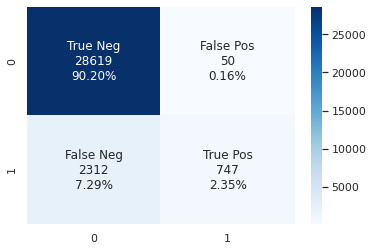

In [189]:
plot_cf(cf)

Each row in a confusion matrix represents an **actual class**, while each column represents a **predicted class**. A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):

**Precision and Recall**

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the **accuracy of the positive predictions**; this is called the **precision** of the classifier (Equation 3-1).

$precision = \frac{TP}{TP + FP}$

A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named **recall**, also called **sensitivity** or **true positive rate** - (TPR): ***this is the ratio of positive instances that are correctly detected by the classifier***

$recall = \frac{TP}{TP + FN}$

In [171]:
from sklearn.metrics import precision_score, recall_score

print("Precision is", precision_score(test.toxic, y_test_pred))

print("Recall is", recall_score(test.toxic, y_test_pred)) #747/(2312+747)

Precision is 0.9372647427854455
Recall is 0.2441974501471069


Our log reg classifier doesn't look as shiny as it did when looking at its accuracy.

It is often convenient to combine precision and recall into a single metric called the **F1
score**, in particular if you need a simple way to compare two classifiers. The F1
score is the **harmonic mean of precision and recall**. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the **classifier will only get a high F1 score if both recall and precision are high**.

$F_{1} = 2 * \frac{precision * recall}{precision + recall}$

In [172]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc

f1_score(test.toxic, y_test_pred)

0.38744813278008294

The **F1 score** favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
sifier that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the clas‐
sifier’s video selection). 

On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the **precision/recall tradeoff**.

**Precision, Recall Tradeoff**

If you raise the threshold, will be increasing precision. Conversely, lowering the threshold increases recall and reduces precision.

Let's plot precision and recall as functions of the threshold value using
Matplotlib

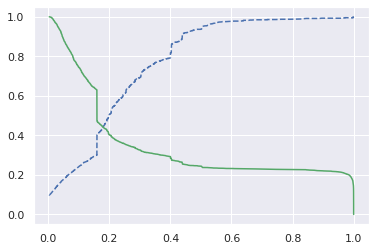

In [204]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

**Precision vs Recall Curve**

In [203]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

precisions, recalls, thresholds = precision_recall_curve(test.toxic, y_test_probs)
f1, auc = f1_score(test.toxic, y_test_pred), auc(recalls, precisions)


In [198]:
def plot_pr_curve(testy, precisions, recalls):
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recalls, precisions, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

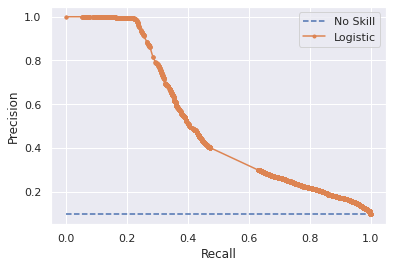

In [199]:
plot_pr_curve(test.toxic, precisions, recalls)

**ROC Curve**

The ROC Curve is a helpful diagnostic for binary classifiers.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.


To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

In [182]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test.toxic, y_test_probs)


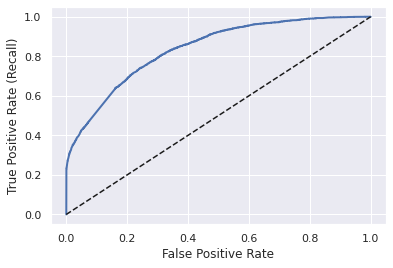

In [185]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
plot_roc_curve(fpr, tpr)
plt.show()


Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:


In [190]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test.toxic, y_test_probs)


0.8375393568720257

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (toxic comments) compared to the negatives
(good comments). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topright corner).

**When to Use ROC vs. Precision-Recall Curves?**

*Read this:* https://stats.stackexchange.com/questions/7207/roc-vs-precision-and-recall-curves

The key difference is that ROC curves will be the same no matter what the baseline probability is, but PR curves may be more useful in practice for needle-in-haystack type problems or problems where the "positive" class is more interesting than the negative class.


IMHO when writing a paper you should provide whichever curve answers the question you want answered (or whichever one is more favorable to your method, if you're cynical). If your question is: "How meaningful is a positive result from my classifier given the baseline probabilities of my problem?", use a PR curve. If your question is, "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?", go with a ROC curve.

Generally, the use of ROC curves and precision-recall curves are as follows:

* **ROC curves** should be used when there are roughly equal numbers of observations for each class.


* **Precision-Recall curves** should be used when there is a moderate to large class imbalance.
    The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.